In [1]:
import gc
import os

import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

random_state = 42

In [2]:
drop_columns = [
    'ID',
    # 'index',
    '기준년월',
    # '상품관련면제카드수_B0M',
    # '임직원면제카드수_B0M',
    # '우수회원면제카드수_B0M',
    # '기타면제카드수_B0M',
    '카드신청건수',
    '이용금액_R3M_체크',
    '이용금액_R3M_체크_가족',
    '유효카드수_체크',
    '유효카드수_체크_가족',
    '이용가능카드수_체크',
    '이용가능카드수_체크_가족',
    '이용카드수_체크',
    '이용카드수_체크_가족',
    '연회비발생카드수_B0M',
    '연회비할인카드수_B0M',
    '기본연회비_B0M',
    '제휴연회비_B0M',
    '할인금액_기본연회비_B0M',
    '할인금액_제휴연회비_B0M',
    '청구금액_기본연회비_B0M',
    '청구금액_제휴연회비_B0M',
    # '캠페인접촉건수_R12M',
    # '캠페인접촉일수_R12M'
]

train = pd.read_parquet(f"../data/6month_avg_train.parquet")
train = train[(train['Segment'] == "A") | (train['Segment'] == "B")]
train["Segment"] = train["Segment"].map({"A" : 0, "B" : 1})
# train.drop([f"Segment_{a}" for a in "ABCDE"], axis=1, inplace=True)

train.drop(drop_columns, axis=1, inplace=True)

gc.collect()

0

In [3]:
missing_columns = train.columns[train.isna().any()]
missing_columns

Index([], dtype='object')

In [4]:
problematic_cols = []

for col in missing_columns:
    if col not in ['Segment']:
        for segment_label in train['Segment'].unique():
            segment_values = train[train['Segment'] == segment_label][col]
            if segment_values.isna().all():
                print(f"⚠️  컬럼 '{col}'은 세그먼트 '{segment_label}'에서 모든 값이 결측치입니다.")
                problematic_cols.append((col, segment_label))

===== Macro F1 Score =====
[0]	validation_0-logloss:0.61975


c:\Users\erich\anaconda3\envs\CustomerSegment\lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:43] WARNING: D:\bld\xgboost-split_1742444198260\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-logloss:0.07128
[100]	validation_0-logloss:0.04663
[150]	validation_0-logloss:0.04650
[200]	validation_0-logloss:0.04650
[250]	validation_0-logloss:0.04650
[299]	validation_0-logloss:0.04650


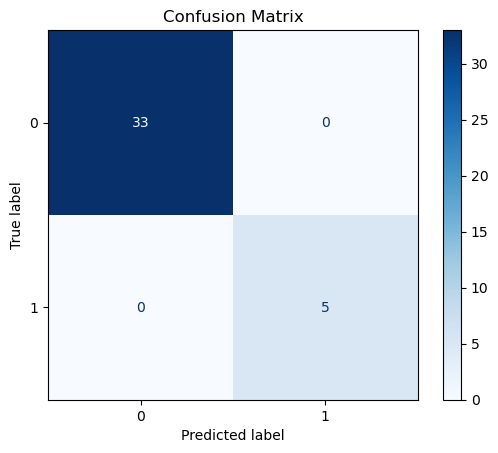

Macro F1 Score: 1.0


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

# 데이터 준비
X = train.drop("Segment", axis=1)
y = train["Segment"]
X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, 
                                           random_state=random_state, stratify=y)

print("===== Macro F1 Score =====")

# 클래스 비율에 맞춰 scale_pos_weight 설정 (예시)
# 실제로는 클래스별 비율을 계산하여 조정하는 것이 바람직
scale_pos_weight = 162 / 24

# 학습/테스트 데이터 분할
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]
y_train = y.loc[X_train_idx]
y_test = y.loc[X_test_idx]

# XGBoost 모델 생성
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)

# 모델 학습
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

# 예측
y_pred = model.predict(X_test)

# 혼동 행렬 출력
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 중요도 추출
score_dict = model.get_booster().get_score(importance_type='gain')
score_series = pd.Series(score_dict, name='importance')
importance_df = score_series.reset_index()
importance_df.columns = ['feature', 'importance']

# NaN 처리 및 정렬
importance_df.fillna(0, inplace=True)
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# F1 점수 출력
score = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {round(score, 5)}")

In [6]:
importance_df

,feature,importance
6,RV신청일자,20.143511
35,평잔_RV일시불_해외_3M,17.492100
36,방문횟수_앱_R6M,15.025949
25,최종카드론_대출일자,5.646704
44,카드이용한도금액_B2M_coef,4.907028
28,이용건수_온라인_R3M,4.897010
34,할인금액_B0M,3.243779
43,카드이용한도금액_B1M_coef,2.374386
16,쇼핑_온라인_이용금액,1.916663
5,CA한도금액,1.866470
